In [1]:
# Reproduce Leaf Counting
# Keras Implementation of ResNet50V2

# Varun Aggarwal


In [1]:
# ensures back compatibility
from tensorflow.keras import backend as K


# for reading and preprocessing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# ResNet50V2 model from keras with pretrained weights
from tensorflow.python.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

import tensorflow as tf


# for plots et al.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


In [2]:
# set these parameters

dataset = 'LeafCount'
modelName = 'ResNet50V2'

load_weights = True

In [3]:
DATASET_PATH  = '../dataset/'

IMAGE_SIZE    = (256, 256)
NUM_CLASSES   = 9  
BATCH_SIZE    = 8
NUM_EPOCHS    = 20
WEIGHTS_FINAL = ''.join(['model-',modelName,'-',dataset,'.h5'])


In [5]:
# specify data augmentation parameters for training images
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   
                                   fill_mode='nearest',
                                   validation_split=0.1)
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset="training",
                                                  classes=['1','2','3','4','5','6','7','8','9+'])

valid_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,                                                                                         subset="validation",
                                                  classes=['1','2','3','4','5','6','7','8','9+'])



Found 6175 images belonging to 9 classes.
Found 681 images belonging to 9 classes.


In [6]:
# show class indices


print('****************')

for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
    
print('****************')

****************
Class #0 = 1
Class #1 = 2
Class #2 = 3
Class #3 = 4
Class #4 = 5
Class #5 = 6
Class #6 = 7
Class #7 = 8
Class #8 = 9+
****************


In [4]:
# inceptionv3 - model setup

model = ResNet50V2(include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

In [5]:
# ResNet model from keras with pretrained weights

# adding final FC layer at the end of model

x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense( NUM_CLASSES,
                      activation='softmax',                     
                      name='softmax')(x)

model = Model(inputs=model.input,
              outputs=output_layer)



# ensure all layers are trainable
for layer in model.layers:
    layer.trainable = True

# setting up optimizer for model
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [6]:
# load saved weights
# if load_weights:
model.load_weights(WEIGHTS_FINAL)

In [14]:
# train the model
hist = model.fit_generator(train_batches,
                    steps_per_epoch = train_batches.samples // BATCH_SIZE,
                    validation_data = valid_batches,
                    validation_steps = valid_batches.samples // BATCH_SIZE,
                    epochs = NUM_EPOCHS)

Epoch 1/20
771/771 [==============================] - 248s 321ms/step - loss: 2.7971 - accuracy: 0.2770 - val_loss: 1.7666 - val_accuracy: 0.3882
Epoch 2/20
771/771 [==============================] - 241s 312ms/step - loss: 1.8548 - accuracy: 0.3598 - val_loss: 1.5456 - val_accuracy: 0.4588
Epoch 3/20
771/771 [==============================] - 241s 312ms/step - loss: 1.6410 - accuracy: 0.4242 - val_loss: 1.4051 - val_accuracy: 0.5029
Epoch 4/20
771/771 [==============================] - 239s 310ms/step - loss: 1.4996 - accuracy: 0.4613 - val_loss: 1.2605 - val_accuracy: 0.5691
Epoch 5/20
771/771 [==============================] - 238s 309ms/step - loss: 1.3946 - accuracy: 0.5024 - val_loss: 1.2092 - val_accuracy: 0.5824
Epoch 6/20
771/771 [==============================] - 240s 312ms/step - loss: 1.3436 - accuracy: 0.5145 - val_loss: 1.1614 - val_accuracy: 0.5794
Epoch 7/20
771/771 [==============================] - 238s 308ms/step - loss: 1.2882 - accuracy: 0.5341 - val_loss: 1.1164 -

In [18]:
# save trained weights
model.save(WEIGHTS_FINAL)



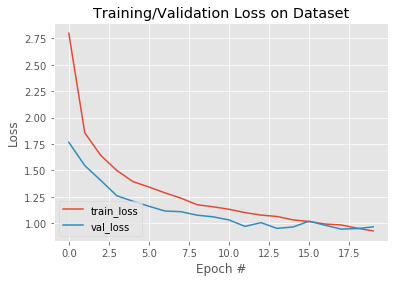

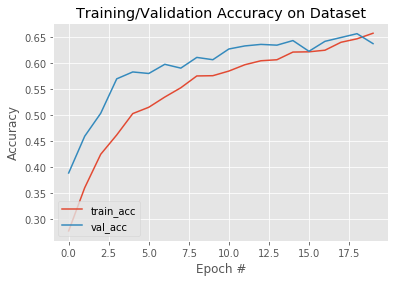

In [15]:
# Plot Results

N=NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")

plt.title("Training/Validation Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig(''.join(['plot_loss-',WEIGHTS_FINAL,'.png']))

plt.figure()
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")

plt.title("Training/Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

plt.savefig(''.join(['plot_acc-',WEIGHTS_FINAL,'.png']))


In [7]:
# test model

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(DATASET_PATH + '/test',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=1,
                                                  classes=['1','2','3','4','5','6','7','8','9+'])

# out = model.evaluate_generator(test_batches, use_multiprocessing=True)
# print(list(zip(model.metrics_names,out)))

Found 2516 images belonging to 9 classes.


In [8]:
test_batches.reset()


In [9]:
Y_pred = model.predict_generator(test_batches, use_multiprocessing=True)
# print(len(Y_pred))




 Classification Report

['1', '2', '3', '4', '5', '6', '7', '8', '9+']
              precision    recall  f1-score   support

           1       0.72      0.92      0.81       225
           2       0.90      0.83      0.87      1096
           3       0.44      0.28      0.34       234
           4       0.64      0.76      0.70       519
           5       0.34      0.25      0.29       127
           6       0.35      0.44      0.39       133
           7       0.00      0.00      0.00        33
           8       0.11      0.03      0.05        33
          9+       0.54      0.79      0.64       116

    accuracy                           0.70      2516
   macro avg       0.45      0.48      0.45      2516
weighted avg       0.69      0.70      0.69      2516



Confusion Matrix



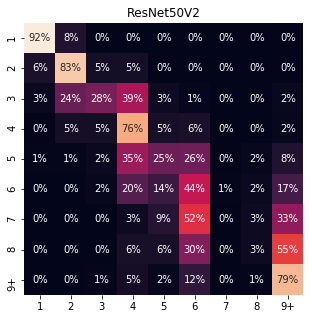

In [10]:
y_pred = np.argmax(Y_pred, axis=1)

print('\n\n Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(target_names)
print(classification_report(list(test_batches.classes), y_pred, target_names=target_names))



print('\n\nConfusion Matrix\n')

cm = confusion_matrix(test_batches.classes, y_pred)

row_sums = cm.sum(axis=1)
cm = cm.T / row_sums
cm = cm.T
# df_cm = pd.DataFrame(cm, index = ['cocklebur','foxtail','pigweed','ragweed'], columns = ['cocklebur','foxtail','pigweed','ragweed'])

df_cm = pd.DataFrame(cm)
# print(df_cm)


# flights = df_cm.pivot("month", "year", "passengers")


plt.figure(figsize = (5,5))

plt.title(modelName)
sn.heatmap(df_cm, annot=True, fmt='0.0%', cbar=False, 
           xticklabels=['1','2','3','4','5','6','7','8','9+'],
           yticklabels=['1','2','3','4','5','6','7','8','9+'])


saveName = ''.join([modelName,'-',dataset,'.png'])
plt.savefig(saveName)
